# Filtrado No-Trivial

Filtrado tradicional con convolución, simplemente es hacer la convolución del kernel con la imagen.

<p align="center">
<img width="600" height="200" src="Images/Image_noise.png"/>
</p>


<p align="center">
<img width="600" height="200" src="Images/Image_noise2.png"/>
</p>

<p align="center">
<img width="600" height="200" src="Images/Image_noise3.png"/>
</p>

## Filtro Blur

Problema con los borderes, elimina el ruido pero difumina la imagen.

In [1]:
import cv2
import numpy as np
from skimage import io, img_as_float
import matplotlib.pyplot as plt

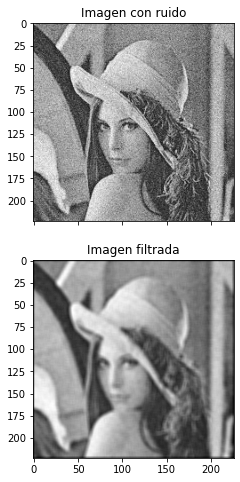

In [30]:
img = cv2.imread('Images/lena_noise.jpg', 0)

kernel = np.ones((5,5), np.float32)/25 #Kernel normalizado
img_blur = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_CONSTANT)

fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(6, 8))
axs[0].set_title('Imagen con ruido')
axs[0].imshow(img, cmap='gray')

axs[1].set_title('Imagen filtrada')
axs[1].imshow(img_blur,  cmap='gray')
plt.show()

## Filtrado Bilateral

Uno de los filtros para eliminar ruido (*denoising filter*) más usados. Este es un filtro preservador de bordes, y lo que hace es reemplazar el valor de cada pixel por el promedio de los píxeles cercanos (vecinos).

$$BF[I]_p = \frac{1}{W_p}\sum_{q\in S}G_{\sigma_s}(||p-q||)G_{\sigma_r}(||I_p-I_q||)I_q$$ 

Donde,

$$W_p = \sum_{q\in S}G_{\sigma_s}(||p-q||)G_{\sigma_r}(||I_p-I_q||)$$ 

Teniendo en cuenta que:
* $G_{\sigma_r}$ es el del núcleo (kernel) de rango para suavizar las diferencias en las intensidades, generalmente es una función Gaussiana.
* $G_{\sigma_s}$ es el del núcleo (kernel) espacial para suavizar las diferencias en las coordenadas, generalmente es una función Gaussiana. 
* $BF[I]_p$ es la imagen filtrada.
* $I_q$ corresponde a la imagen de entrada


Se combinan los dos filtros obteniendo un nuevo kernel que suavisa la señal eliminando el ruido.


<p align="center">
<img width="600" height="200" src="Images/Gaussian.png"/>
</p>
   
<p align="center">
<img width="600" height="200" src="Images/BilateralFilter.png"/>
</p>

### ¿Comó preserva los bordes?
Como se menciona el filtrado bilateral hace el filtrado gasussiano en el espacio, pero también hace otro filtrado Gaussiano de diferencia entre pixeles. En otras palabras, el primer filtro Gaussiano en el espacio hace que solo los pixeles cercanos sean considerados, mientras que el filtro Gaussiano de diferencia en intensidad hace que solo los pixeles con intensidades similares sean considerados. Esto resulta en la preservacion de los bordes, ya que estos tendrán una mayor variación de intensisdad y no se verán alterados. 

### Filtrado Bilateral utilizando OpenCV

In [14]:
import cv2
import numpy as np
from skimage import io, img_as_float
import matplotlib.pyplot as plt

[]

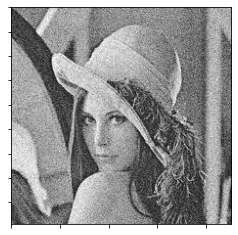

In [41]:
#Lectura de la imagen
img = cv2.imread('Images/lena_noise.jpg', 0)
plt.imshow(img, cmap='gray')
plt.gca().axes.yaxis.set_ticklabels([])
plt.gca().axes.xaxis.set_ticklabels([])

### Uso del filtro de OpenCV

```
dst = cv.bilateralFilter(src, d, sigmaColor, sigmaSpace[, dst[, borderType]])
```

La señal de entrada debe ser de punto flotante o un 8-bits, de 1 o 3 canales.

* **d:** diametro de cada pixel vecino que se esta utilizando durante el filtrado. (Se puede ver como el tamaño del kernel).

* **sigmaColor:** Desviasión estandar para el filtro de intensidad.

* **sigmaSpace:** Desviasión estandar para el filtro de espacio.

* **borderType:** Forma de tratar los bordes, si se usará padding o si se recortará la imagen de salida

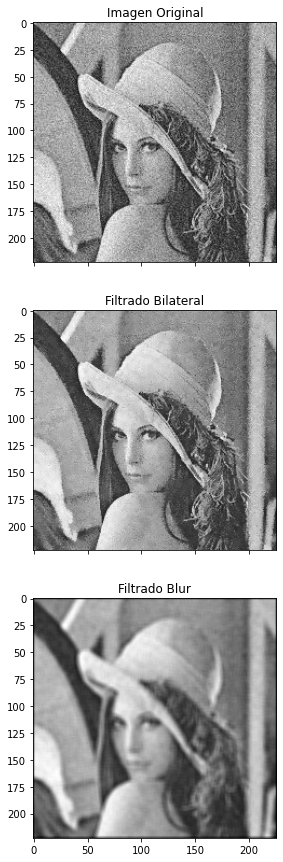

In [50]:
bilateral_using_cv2 = cv2.bilateralFilter(img,7, 20, 20, borderType=cv2.BORDER_CONSTANT)

fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(10, 15))
axs[0].set_title('Imagen Original')
axs[0].imshow(img, cmap='gray')

axs[1].set_title('Filtrado Bilateral')
axs[1].imshow(bilateral_using_cv2, cmap='gray')

axs[2].set_title('Filtrado Blur')
axs[2].imshow(img_blur,  cmap='gray')
plt.show()

## Filtrado Non-Local Means

Uno de los filtros para eliminar ruido (*denoising filter*) más usados. Este es un filtro preservador de bordes, y lo que hace es reemplazar el valor de cada pixel por el promedio de los píxeles **similares**.

Como su nombre lo indica: 

* Calcula el promedio de pixeles seleccionados (mean)
* La selección no es necesariamente de pixeles próximos o también llamados vecinos (non-local) 

¿Que significa esto?

Toda imagen posee areas que similares, y lo que se va a hacer el algoritmo es encontar esas regiones similares y promediarlas. Esta similitud se mide meidante una distancia gaussiana.


<p align="center">
<img width="600" height="200" src="Images/nlmean.png"/>
</p>

En otras palabras, el algoritmo lo que hace es encontrar familias que se parezcan a la familia que se esta analizando, y se les asigna un peso, acorde a que tan similares son y luego se saca el promedio con ese peso.


$$NL(u(i)) = \sum_{j\in I}\omega(i,j)u(j)$$

$$\omega(i,j) =  \frac{1}{Z(i)} \cdot e^{\frac{-||v(N_p)-v(N_r)||^2_{2,a}}{h^2}}$$

$$\omega(p,r)= \sum_{j\in I}e^{\frac{-||v(N_p)-v(N_r)||^2_{2,a}}{h^2}}$$

Donde,
$\omega(i,j)$ Corresponde al conjunto de pesos que depende de la similitud entre el pixel i y el pixel j, y se cumple la condición que $\sum_j \omega(i,j)= 1$. 

Ahora esa similitud entre los pixeles i y j depende de la similitud de la intendisdad de los niveles de los vectores $v(N_i)$ y $v(N_j)$ donde todo vector $N_k$ corresponde a un vecindario cuadrado de tamaño fijo centrado en el píxel k.

El parámetro h actúa como el grado del filtro. Este parametro controla la decadencia de la función exponencial y por lo tanto el de los pesos.

### Filtrado Non-Local Mean utilizando Skimage

In [16]:
#Genearal imports
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float

#OpenCV import
import cv2

#Skimage non-mean filter import
from skimage.restoration import denoise_nl_means, estimate_sigma

[]

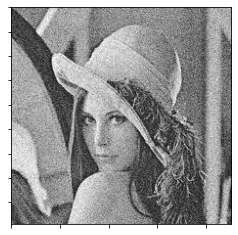

In [17]:
#Lectura de la imagen
img = cv2.imread('Images/lena_noise.jpg', 0)
plt.imshow(img, cmap='gray')
plt.gca().axes.yaxis.set_ticklabels([])
plt.gca().axes.xaxis.set_ticklabels([])

### Uso del filtro de Skimage

```
dst = cv.fastNlMeansDenoising(src, h, search_window, block_size)
```

* **src:** La señal de entrada debe ser de punto flotante o un 8-bits, de 1 o 3 canales.

* **h:** Parámetro que establece la intensidad del filtro. Un h alto, remueve el ruido pero también elimina características de la imagen.

* **patch_distance:** Indica que tan lejos se puede recorrer en la imagen a partir del pixel a filtrar para encontrar ventanas similares.

* **patch_size:** Especifica el tamaño de tamaño de las familias que se utiliza para hacer el cálculo, debe ser un número impar.

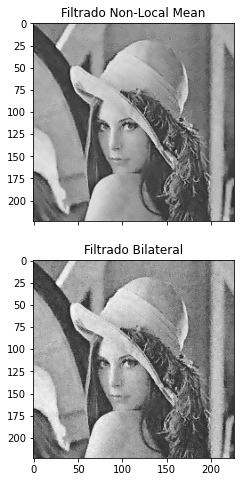

In [75]:
img_nlm = denoise_nl_means(img, 
                               h=1.*sigma_est, 
                               fast_mode=True, 
                               patch_size=5,
                               patch_distance=3)

fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(6, 8))
axs[0].set_title('Filtrado Non-Local Mean')
axs[0].imshow(img_nlm, cmap='gray')

axs[1].set_title('Filtrado Bilateral')
axs[1].imshow(bilateral_using_cv2,  cmap='gray')
plt.show()

## Filtrado Homomórfico

# Anexos